<a href="https://colab.research.google.com/github/DrAlexSanz/NLP-SPEC-C3/blob/main/W3/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 3 - Named Entity Recognition (NER)
Welcome to the third programming assignment of Course 3. In this assignment, you will learn to build more complicated models with Trax. By completing this assignment, you will be able to:

* Design the architecture of a neural network, train it, and test it.
* Process features and represents them
* Understand word padding
* Implement LSTMs
* Test with your own sentence

## Introduction

We first start by defining named entity recognition (NER). NER is a subtask of information extraction that locates and classifies named entities in a text. The named entities could be organizations, persons, locations, times, etc.

For example:

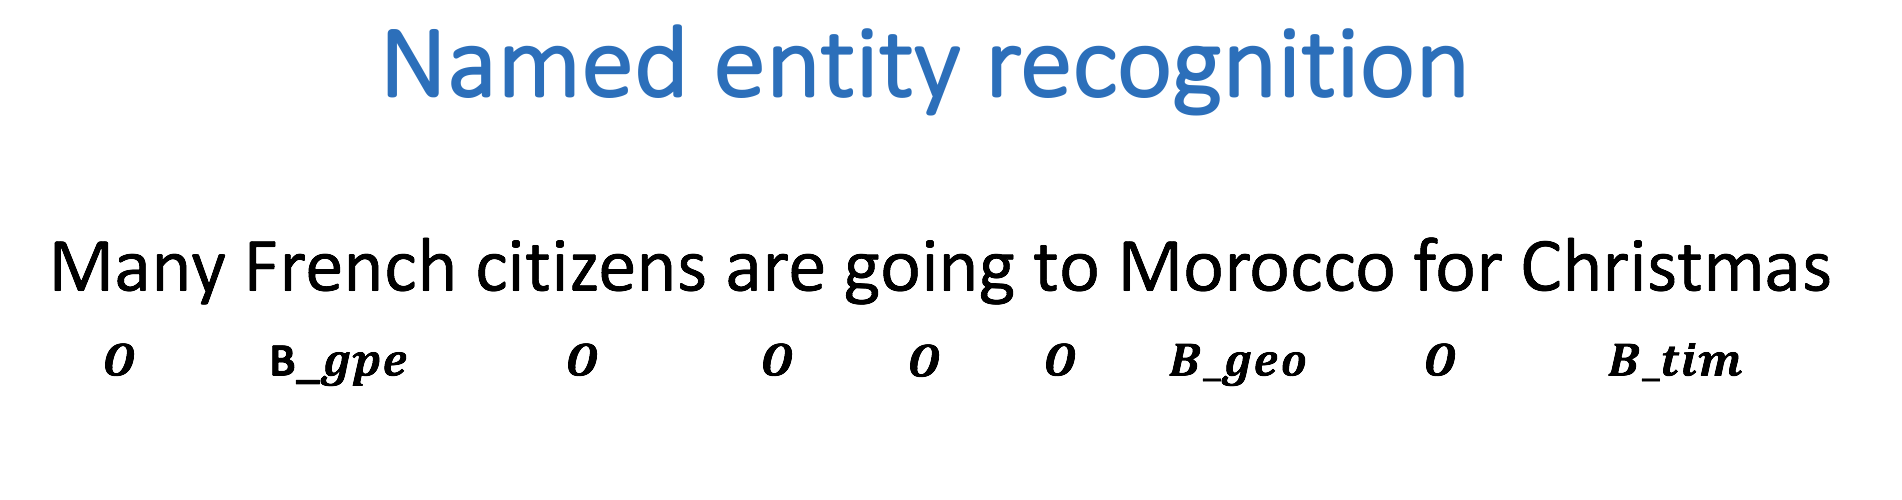

Is labeled as follows:

* French: geopolitical entity
* Morocco: geographic entity
* Christmas: time indicator

Everything else that is labeled with an O is not considered to be a named entity. In this assignment, you will train a named entity recognition system that could be trained in a few seconds (on a GPU) and will get around 75% accuracy. Then, you will load in the exact version of your model, which was trained for a longer period of time. You could then evaluate the trained version of your model to get 96% accuracy! Finally, you will be able to test your named entity recognition system with your own sentence.

In [2]:
#!pip install sentencepiece==0.1.91
!pip install trax==1.3.1

import trax

import os
import numpy
from trax import fastmath
from trax import layers as tl
import random as rnd
from trax.supervised import training
import numpy as np
import pandas as pd



In [ ]:
%pwd

In [3]:
# if os.path.exists("/content/Repo"):
#     %rm -rf "/content/Repo"
#     %cd "/content"
#     print("yes")

!git clone -l -s https://github.com/DrAlexSanz/NLP-SPEC-C3.git Repo
%cd Repo
%rm -rf W1
%rm -rf W2
%mv ./W3/* ./
%rm -rf W3

from utils import get_params, get_vocab

Cloning into 'Repo'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 218 (delta 18), reused 47 (delta 4), pack-reused 128
Receiving objects: 100% (218/218), 13.69 MiB | 6.03 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/Repo


## Part 1: Exploring the data
We will be using a dataset from Kaggle, which we will preprocess for you. The original data consists of four columns, the sentence number, the word, the part of speech of the word, and the tags. A few tags you might expect to see are:

* geo: geographical entity
* org: organization
* per: person
* gpe: geopolitical entity
* tim: time indicator
* art: artifact
* eve: event
* nat: natural phenomenon
* O: filler word

In [4]:
data = pd.read_csv("ner_dataset.csv", encoding = "ISO-8859-1")

train_sentences = open("data/small/train/sentences.txt", "r").readline()
train_labels = open("data/small/train/labels.txt", "r").readline()

print(train_sentences)
print(train_labels)
print(data.head())
del data, train_sentences, train_labels

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .

O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O

    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O


## 1.1 Importing the Data
In this part, we will import the preprocessed data and explore it.

In [6]:
vocab, tag_map = get_vocab("data/large/words.txt", "data/large/tags.txt")

t_sentences, t_labels, t_size = get_params(vocab, tag_map, "data/large/train/sentences.txt", "data/large/train/labels.txt")
v_sentences, v_labels, v_size = get_params(vocab, tag_map, "data/large/val/sentences.txt", "data/large/val/labels.txt")
test_sentences, test_labels, test_size = get_params(vocab, tag_map, "data/large/test/sentences.txt", "data/large/test/labels.txt")

vocab is a dictionary that translates a word string to a unique number. Given a sentence, you can represent it as an array of numbers translating with this dictionary. The dictionary contains a <PAD> token.

When training an LSTM using batches, all your input sentences must be the same size. To accomplish this, you set the length of your sentences to a certain number and add the generic <PAD> token to fill all the empty spaces.

In [7]:
# Vocab is a dictionary where the keys are the words and the values are the tokens (ID)

print("The token of THE is", vocab["the"])
print("The token of PAD is", vocab["<PAD>"])

The token of THE is 9
The token of PAD is 35180


The tag_map corresponds to one of the possible tags a word can have. Run the cell below to see the possible classes you will be predicting. The prepositions in the tags mean:

* I: Token is inside an entity.
* B: Token begins an entity.

In [8]:
print(tag_map)

{'O': 0, 'B-geo': 1, 'B-gpe': 2, 'B-per': 3, 'I-geo': 4, 'B-org': 5, 'I-org': 6, 'B-tim': 7, 'B-art': 8, 'I-art': 9, 'I-per': 10, 'I-gpe': 11, 'I-tim': 12, 'B-nat': 13, 'B-eve': 14, 'I-eve': 15, 'I-nat': 16}


So the coding scheme that tags the entities is a minimal one where B- indicates the first token in a multi-token entity, and I- indicates one in the middle of a multi-token entity. If you had the sentence

**"Sharon flew to Miami on Friday"**

the outputs would look like:

  * Sharon B-per
  * flew   O
  * to     O
  * Miami  B-geo
  * on     O
  * Friday B-tim

your tags would reflect three tokens beginning with B-, since there are no multi-token entities in the sequence. But if you added Sharon's last name to the sentence:

**"Sharon Floyd flew to Miami on Friday"**

  * Sharon B-per
  * Floyd  I-per
  * flew   O
  * to     O
  * Miami  B-geo
  * on     O
  * Friday B-tim

then your tags would change to show first "Sharon" as B-per, and "Floyd" as I-per, where I- indicates an inner token in a multi-token sequence.

In [12]:
print("The total number of tags is:", len(tag_map))
g_vocab_size = len(vocab)
print(f"The total number of words I have is {g_vocab_size}")
print("The training size is", t_size)
print("The validation size is", v_size)
print("The test size is", test_size)
print("The first sentence is", t_sentences[0])
print("The tags of the first sentences are", t_labels[0])

The total number of tags is: 17
The total number of words I have is 35181
The training size is 33570
The validation size is 7194
The test size is 7194
The first sentence is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 9, 15, 1, 16, 17, 18, 19, 20, 21]
The tags of the first sentences are [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]


So you can see that we have already encoded each sentence into a tensor by converting it into a number. We also have 16 possible classes, as shown in the tag map.

##1.2 Data generator
In python, a generator is a function that behaves like an iterator. It will return the next item. Here is a link to review python generators.

In many AI applications it is very useful to have a data generator. You will now implement a data generator for our NER application.


### Exercise 01
Instructions: Implement a data generator function that takes in batch_size, x, y, pad, shuffle where x is a large list of sentences, and y is a list of the tags associated with those sentences and pad is a pad value. Return a subset of those inputs in a tuple of two arrays (X,Y). Each is an array of dimension (batch_size, max_len), where max_len is the length of the longest sentence in that batch. You will pad the X and Y examples with the pad argument. If shuffle=True, the data will be traversed in a random form.

Details:

This code as an outer loop

> while True:

> ...  

> yield((X,Y))


Which runs continuously in the fashion of generators, pausing when yielding the next values. We will generate a batch_size output on each pass of this loop.

It has two inner loops.

* The first stores in temporal lists the data samples to be included in the next batch, and finds the maximum length of the sentences contained in it. By adjusting the length to include only the size of the longest sentence in each batch, overall computation is reduced.

* The second loop moves those inputs from the temporal list into NumPy arrays pre-filled with pad values.

There are three slightly out of the ordinary features.

* The first is the use of the NumPy full function to fill the NumPy arrays with a pad value. See full function documentation.

* The second is tracking the current location in the incoming lists of sentences. Generators variables hold their values between invocations, so we create an index variable, initialize to zero, and increment by one for each sample included in a batch. However, we do not use the index to access the positions of the list of sentences directly. Instead, we use it to select one index from a list of indexes. In this way, we can change the order in which we traverse our original list, keeping untouched our original list.

* The third also relates to wrapping. Because batch_size and the length of the input lists are not aligned, gathering a batch_size group of inputs may involve wrapping back to the beginning of the input loop. In our approach, it is just enough to reset the index to 0. We can re-shuffle the list of indexes to produce different batches each time.

In [18]:
def data_generator(batch_size, x, y, pad, shuffle = False, verbose = False):
    """
    Generates the next batch
    Input:
      batch size: int
      x: list of sentences (ints)
      y: list of tags
      pad: int representing the pad character (no need to pass the whole vocab)
    Output:
      X: a np.array of dim(batch_size, max_length) containing the sentences in this batch
      Y: a np.array of dim(batch_size, max_length) of tags of the sentences    
    """

    num_lines = len(x)

    lines_index = [*range(num_lines)]

    if shuffle:
        rnd.shuffle(lines_index)
    
    index = 0

    while True:
        buffer_x = [0] * batch_size
        buffer_y = [0] * batch_size # These are temp arrays Could be done with np.zeros

        max_length = 0

        # Copy into the temporal buffers the sentences in x[index : index + batch_size] 
        # along with their corresponding labels y[index : index + batch_size]
        # Find maximum length of sentences in x[index : index + batch_size] for this batch. 
        # Reset the index if we reach the end of the data set, and shuffle the indexes if needed.

        for i in range(batch_size):
            if index >= num_lines:
                index = 0
                if shuffle == True:
                    rnd.shuffle(index)

            buffer_x[i] = x[lines_index[index]]
            buffer_y[i] = y[lines_index[index]]

            lenx = len(x[lines_index[index]])
            if lenx > max_length:
                max_length = lenx
            index += 1

        X = np.full((batch_size, max_length), pad)
        Y = np.full((batch_size, max_length), pad)

        for i in range(batch_size):
            x_i = buffer_x[i]
            y_i = buffer_y[i]

            for j in range(len(x_i)):
                X[i, j] = x_i[j]
                Y[i, j] = y_i[j]

        if verbose:
            print("Index:", index)
        
        yield X, Y

In [19]:
batch_size = 5

mini_sentences = t_sentences[0:8]
mini_labels = t_labels[0:8]

dg = data_generator(batch_size, mini_sentences, mini_labels, vocab["<PAD>"], shuffle = False, verbose = True)

X1, Y1 = next(dg)
X2, Y2 = next(dg)

print(X1.shape, Y1.shape, X2.shape, Y2.shape)
print(X1[0, :])
print(Y1[0, :])


Index: 5
Index: 2
(5, 30) (5, 30) (5, 30) (5, 30)
[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14     9    15     1    16    17    18    19    20    21
 35180 35180 35180 35180 35180 35180]
[    0     0     0     0     0     0     1     0     0     0     0     0
     1     0     0     0     0     0     2     0     0     0     0     0
 35180 35180 35180 35180 35180 35180]


# Part 2: Building the model
You will now implement the model. You will be using Google's TensorFlow.
**Mentira cochina. Seguimos con el trax este de las narices.**
Your model will be able to distinguish the following:

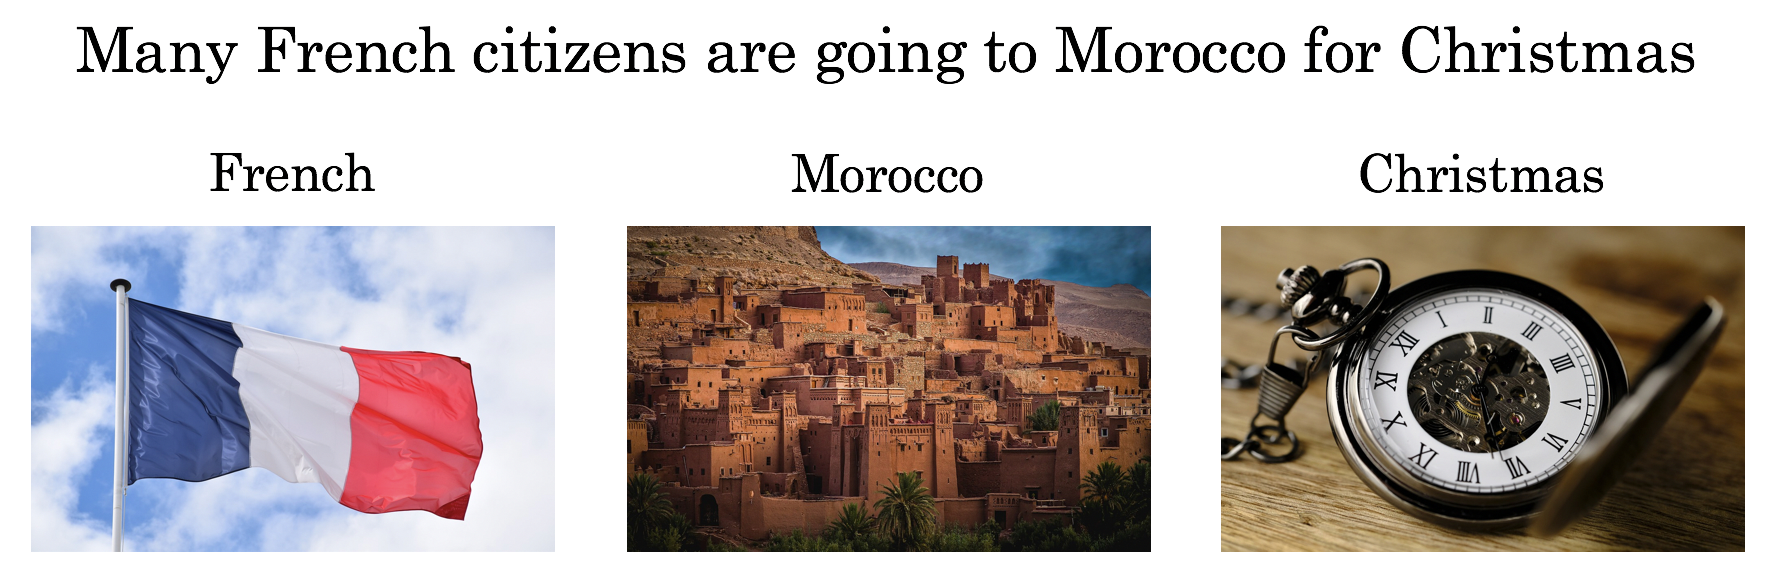

The model architecture will be as follows:

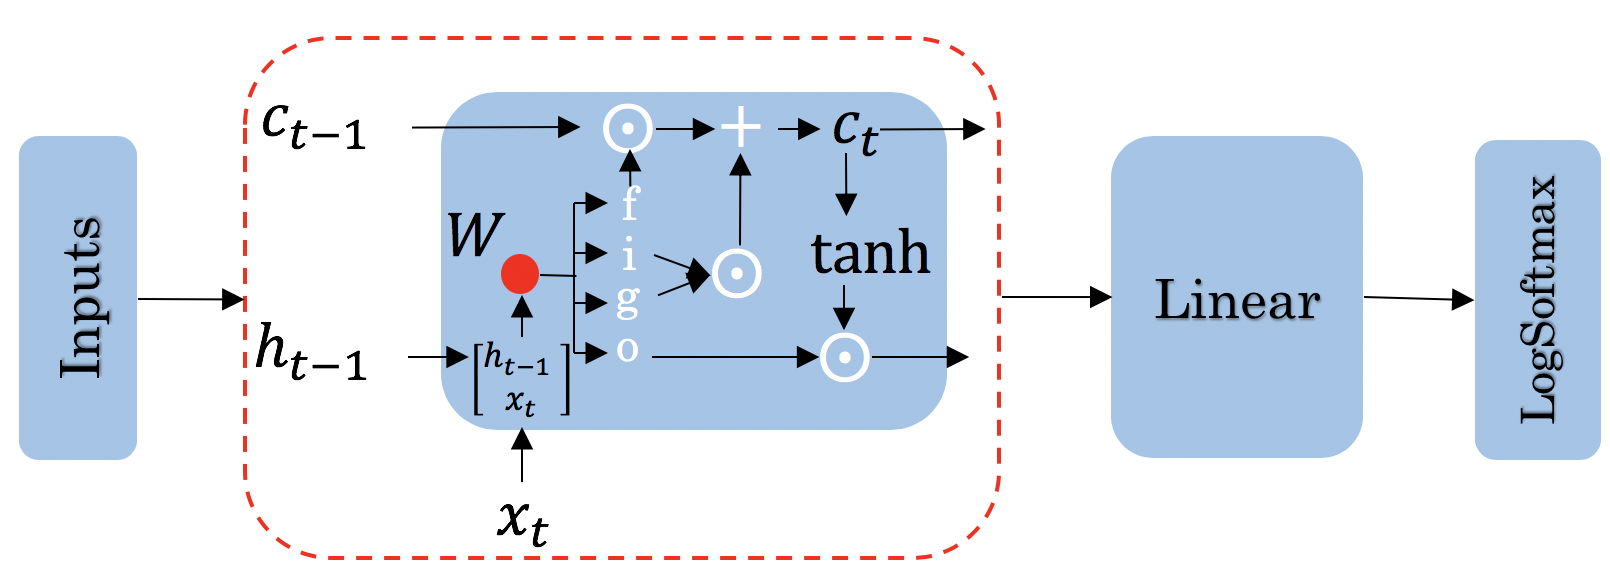

Concretely:

* Use the input tensors you built in your data generator
* Feed it into an Embedding layer, to produce more semantic entries
* Feed it into an LSTM layer
* Run the output through a linear layer
* Run the result through a log softmax layer to get the predicted class for each word.

Good news! We won't make you implement the LSTM unit drawn above. However, we will ask you to build the model.

## Exercise 02
Instructions: Implement the initialization step and the forward function of your Named Entity Recognition system.
Please utilize help function e.g. help(tl.Dense) for more information on a layer

* tl.Serial: Combinator that applies layers serially (by function composition).
  * You can pass in the layers as arguments to Serial, separated by commas.
  * For example: tl.Serial(tl.Embeddings(...), tl.Mean(...), tl.Dense(...), tl.* LogSoftmax(...))
* tl.Embedding: Initializes the embedding. In this case it is the dimension of the model by the size of the vocabulary.
  * tl.Embedding(vocab_size, d_feature).
vocab_size is the number of unique words in the given vocabulary.
  * d_feature is the number of elements in the word embedding (some choices for a word embedding size range from 150 to 300, for example).
* tl.LSTM:Trax LSTM layer of size d_model.
LSTM(n_units) Builds an LSTM layer of n_cells.
* tl.Dense: A dense layer.
  * tl.Dense(n_units): The parameter n_units is the number of units chosen for this dense layer.
* tl.LogSoftmax: Log of the output probabilities.
  * Here, you don't need to set any parameters for LogSoftMax().

In [20]:
def NER(vocab_size = len(vocab), d_model = 50, tags = tag_map):
    """
    Returns a trax model
    Inputs:
      vocab size: Let's make it a parameter
      d_model: size of the embedding
    Output:
      trax model
    """

    model = tl.Serial(
                      tl.Embedding(vocab_size, d_model), # I guess I'm training the embeddings
                      tl.LSTM(d_model),
                      tl.Dense(len(tags)),
                      tl.LogSoftmax(),
                      )
    
    return model

In [21]:
model = NER()
display(model)

Serial[
  Embedding_35181_50
  LSTM_50
  Dense_17
  LogSoftmax
]

# Part 3: Train the Model
This section will train your model.

Before you start, you need to create the data generators for training and validation data. It is important that you mask padding in the loss weights of your data, which can be done using the `id_to_mask` argument of `trax.supervised.inputs.add_loss_weights.`